# RQ3: Are LLMs less skilled for creative writing in languages other than English?

In [1]:
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
data = pd.read_csv('data/expert_assessment.csv')
data['synopsis_writer_specific'] = data['synopsis_writer']+data['experiment']

In [3]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'username', '1_attractive_title',
       '1_attractive_style', '1_attractive_theme', '2_originality_title',
       '2_originality_style', '2_originality_theme', '3_relevance',
       '4_creativity_title', '4_creativity_synopsis', '4_creativity_comment',
       '5_authorship_title', '5_authorship_synopsis', '5_authorship_comment',
       '6_anthology', '6_readers_opinion', '6_critics_opinion', '6_own_voice',
       '6_comment', 'title', 'title_id', 'synopsis_writer', 'title_writer',
       'experiment', 'synopsis_writer_specific'],
      dtype='object')

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Assuming your dataset is called 'data' and is already loaded as a pandas DataFrame
# First, correct column names that start with numbers
data.columns = ['X' + col if col[0].isdigit() else col for col in data.columns]

# List of columns of interest (ensure all are included)
attributes = ['X1_attractive_style', 'X1_attractive_theme',
              'X2_originality_style', 'X2_originality_theme',
              'X4_creativity_synopsis',
              'X6_anthology', 'X6_own_voice']

# Filter data to include 'patricio', 'gpt4_en', and 'gpt4_es'
data_interest = data[data['synopsis_writer'].isin(['patricio', 'gpt4_en', 'gpt4_es'])].copy()

# Create a new variable that identifies 'patricio' and 'gpt4'
data_interest['writer_group'] = data_interest['synopsis_writer'].apply(
    lambda x: 'patricio' if x == 'patricio' else 'gpt4'
)

# Pivot the data to have separate columns for 'patricio' and 'gpt4'
# We need to identify the columns that will be the keys for the pivot
index_cols = ['username', 'title_id', 'experiment']

# Perform the pivot
differences = data_interest.pivot_table(
    index=index_cols,
    columns='writer_group',
    values=attributes,
    aggfunc='first'  # If there are duplicates, take the first value
).reset_index()

# Flatten the resulting MultiIndex columns
# Adjustment in the flattening function to correctly preserve column names
differences.columns = ['_'.join([str(c) for c in col if c and not str(c).isspace()]).strip('_') if isinstance(col, tuple) else str(col) for col in differences.columns]

# Check if 'experiment' is in differences.columns
print("'experiment' is in differences.columns:", 'experiment' in differences.columns)

# Calculate differences for each attribute
for attribute in attributes:
    # Check that columns exist before calculating the difference
    col_gpt4 = f'{attribute}_gpt4'
    col_patricio = f'{attribute}_patricio'
    if col_gpt4 in differences.columns and col_patricio in differences.columns:
        differences[f'diff_{attribute}'] = differences[col_gpt4] - differences[col_patricio]
    else:
        print(f'Warning: Missing columns for {attribute}, difference calculation omitted.')

# Now, we can compare the differences between experiments
p_values = []
valid_attributes = []

for attribute in attributes:
    diff_col = f'diff_{attribute}'
    
    # Check if the difference column exists
    if diff_col in differences.columns:
        # Filter rows where there is no NA in the difference
        if 'experiment' in differences.columns:
            diff_data = differences[['experiment', diff_col]].dropna()
        else:
            print("The 'experiment' column is not in differences.columns")
            continue
        
        if not diff_data.empty:
            group1 = diff_data[diff_data['experiment'] == 'ENGLISH'][diff_col]
            group2 = diff_data[diff_data['experiment'] == 'SPANISH'][diff_col]
            
            # Check normality using the Shapiro-Wilk test
            stat1, p1 = stats.shapiro(group1)
            stat2, p2 = stats.shapiro(group2)
            normal1 = p1 > 0.05
            normal2 = p2 > 0.05
            
            print(f'\nAnalysis for {attribute}:')
            print(f'Shapiro-Wilk test p-value ENGLISH: {p1:.4f} (Normal: {normal1})')
            print(f'Shapiro-Wilk test p-value SPANISH: {p2:.4f} (Normal: {normal2})')
            
            if normal1 and normal2:
                # Check homogeneity of variances
                stat_levene, p_levene = stats.levene(group1, group2)
                print(f"Levene's test p-value: {p_levene:.4f}")
                equal_var = p_levene > 0.05
                # If variances are homogeneous, use t-test with equal variances
                stat, p_value = stats.ttest_ind(group1, group2, equal_var=equal_var)
                test_used = 't-test (equal variances)' if equal_var else 't-test (unequal variances)'
            else:
                # Use Mann-Whitney U if normality assumptions are not met
                stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                test_used = 'Mann-Whitney U'
            
            print(f'{test_used} for {diff_col}: statistic={stat:.4f}, p-value={p_value:.4f}')
            
            # Store p-values for multiple correction
            p_values.append(p_value)
            valid_attributes.append(attribute)
            
            # Interpretation
            alpha = 0.05
            if p_value < alpha:
                print(f'→ There is a significant difference in {attribute} between ENGLISH and SPANISH (p < {alpha}).')
            else:
                print(f'→ There is no significant difference in {attribute} between ENGLISH and SPANISH (p ≥ {alpha}).')
        else:
            print(f'Not enough data for {attribute}.')
    else:
        print(f'The column {diff_col} does not exist in the data.')

# Correction for multiple comparisons (Bonferroni)
if p_values:
    corrected = multipletests(p_values, method='bonferroni')
    corrected_p_values = corrected[1]
    print('\nBonferroni corrected results:')
    for i, attribute in enumerate(valid_attributes):
        print(f'{attribute}: corrected p-value = {corrected_p_values[i]:.4f}')
        if corrected_p_values[i] < alpha:
            print(f'→ Significant difference (p < {alpha})')
        else:
            print(f'→ No significant difference (p ≥ {alpha})')


'experiment' is in differences.columns: True

Analysis for X1_attractive_style:
Shapiro-Wilk test p-value ENGLISH: 0.0000 (Normal: False)
Shapiro-Wilk test p-value SPANISH: 0.0000 (Normal: False)
Mann-Whitney U for diff_X1_attractive_style: statistic=19821.5000, p-value=0.0001
→ There is a significant difference in X1_attractive_style between ENGLISH and SPANISH (p < 0.05).

Analysis for X1_attractive_theme:
Shapiro-Wilk test p-value ENGLISH: 0.0000 (Normal: False)
Shapiro-Wilk test p-value SPANISH: 0.0000 (Normal: False)
Mann-Whitney U for diff_X1_attractive_theme: statistic=18409.0000, p-value=0.0206
→ There is a significant difference in X1_attractive_theme between ENGLISH and SPANISH (p < 0.05).

Analysis for X2_originality_style:
Shapiro-Wilk test p-value ENGLISH: 0.0000 (Normal: False)
Shapiro-Wilk test p-value SPANISH: 0.0000 (Normal: False)
Mann-Whitney U for diff_X2_originality_style: statistic=20582.0000, p-value=0.0000
→ There is a significant difference in X2_originality_st

In [5]:
# 1. Identificar las columnas que comienzan con 'diff_'
diff_columns = [col for col in differences.columns if col.startswith('diff_')]

# 2. Agrupar por 'title_id' y 'experiment' y calcular la media de las columnas de differences
mean_diffs = differences.groupby(['title_id', 'experiment'])[diff_columns].mean().reset_index()


# Plotting difference averages

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar columnas que empiezan con 'diff_'
columnas_diff = [col for col in differences.columns if col.startswith('diff_')]

# Calcular las medias para 'SPANISH' y 'ENGLISH'
medias_spanish = differences[differences['experiment'] == 'SPANISH'][columnas_diff].mean()
medias_english = differences[differences['experiment'] == 'ENGLISH'][columnas_diff].mean()

# Verificar las medias obtenidas
print("Medias SPANISH:")
print(medias_spanish)
print("\nMedias ENGLISH:")
print(medias_english)


Medias SPANISH:
diff_X1_attractive_style      -1.277778
diff_X1_attractive_theme      -0.816667
diff_X2_originality_style     -1.450000
diff_X2_originality_theme     -0.938889
diff_X4_creativity_synopsis   -1.305556
diff_X6_anthology             -0.994444
diff_X6_own_voice             -1.544444
dtype: float64

Medias ENGLISH:
diff_X1_attractive_style      -0.883333
diff_X1_attractive_theme      -0.605556
diff_X2_originality_style     -0.955556
diff_X2_originality_theme     -0.683333
diff_X4_creativity_synopsis   -0.872222
diff_X6_anthology             -0.594444
diff_X6_own_voice             -0.800000
dtype: float64


In [7]:
map_columns = {'diff_X1_attractive_style':'Style Attractiveness',
  'diff_X1_attractive_theme':'Theme Attractiveness',
  'diff_X2_originality_style':'Style Originality',
  'diff_X2_originality_theme':'Theme Originality',
  'diff_X4_creativity_synopsis':'Creativity',
  'diff_X6_anthology':'Anthology',
  'diff_X6_own_voice':'Own Voice'}

In [8]:
import matplotlib.pyplot as plt
import matplotlib

# Configurar la fuente de toda la figura en Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

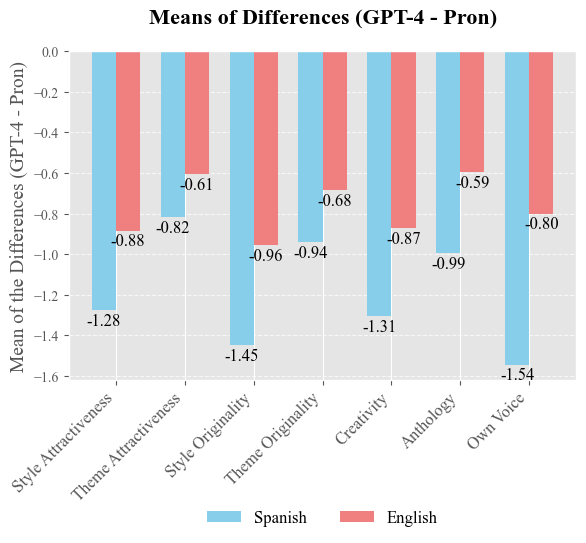

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib

# Configurar la fuente de toda la figura en Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

# Crear el diccionario de mapeo para los nombres de las columnas
map_columns = {
    'diff_X1_attractive_style': 'Style Attractiveness',
    'diff_X1_attractive_theme': 'Theme Attractiveness',
    'diff_X2_originality_style': 'Style Originality',
    'diff_X2_originality_theme': 'Theme Originality',
    'diff_X4_creativity_synopsis': 'Creativity',
    'diff_X6_anthology': 'Anthology',
    'diff_X6_own_voice': 'Own Voice'
}

# Reemplazar los nombres de las columnas con los del diccionario de mapeo
columnas_diff_mapeadas = [map_columns.get(col, col) for col in columnas_diff]

# Configurar el estilo 'ggplot'
plt.style.use('ggplot')

# Crear la figura y los ejes del gráfico con el tamaño solicitado (6 pulgadas de ancho)
fig, ax = plt.subplots(figsize=(6, 6))

# Definir el número de columnas 'diff_' para configurar las posiciones de las barras
ind = range(len(columnas_diff))  # Posiciones para las barras

# Ancho de las barras
width = 0.35

# Crear las barras para 'SPANISH' y 'ENGLISH'
bars_spanish = ax.bar(ind, medias_spanish, width, label='Spanish', color='skyblue')
bars_english = ax.bar([i + width for i in ind], medias_english, width, label='English', color='lightcoral')

# Añadir etiquetas y título
ax.set_ylabel('Mean of the Differences (GPT-4 - Pron)', fontsize=14)
ax.set_title('Means of Differences (GPT-4 - Pron)', fontsize=16, fontweight='bold', pad=20)

# Reemplazar los nombres en el eje X usando las columnas mapeadas
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(columnas_diff_mapeadas, rotation=45, ha="right", fontsize=12)

# Añadir cuadrícula
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

# Añadir los valores sobre las barras
for bar in bars_spanish:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -14),  # Desplazamiento de 12 puntos abajo de la barra
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

for bar in bars_english:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, -14),  # Desplazamiento de 12 puntos abajo de la barra
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

# Añadir la leyenda debajo del gráfico
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), fontsize=12, ncol=2, frameon=False)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Guardar el gráfico como PDF con un ajuste para evitar márgenes adicionales
plt.savefig('figures/RQ3_comparison_diff_means.pdf', format='pdf', bbox_inches='tight')

# Mostrar el gráfico
plt.show()


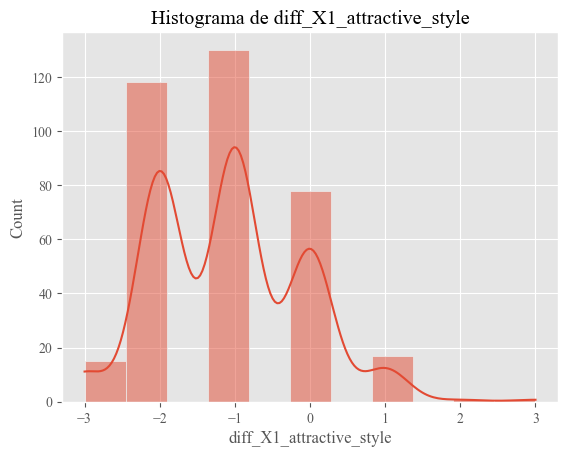

Prueba de Shapiro-Wilk para diff_X1_attractive_style: estadístico=0.8965642022553304, p-valor=6.448875018555425e-15


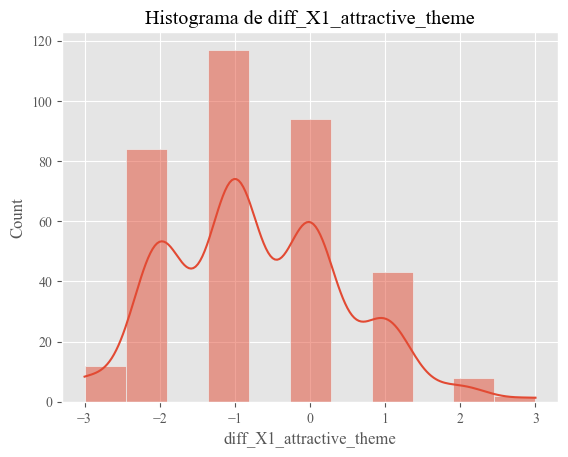

Prueba de Shapiro-Wilk para diff_X1_attractive_theme: estadístico=0.9251234231533374, p-valor=1.935960727889035e-12


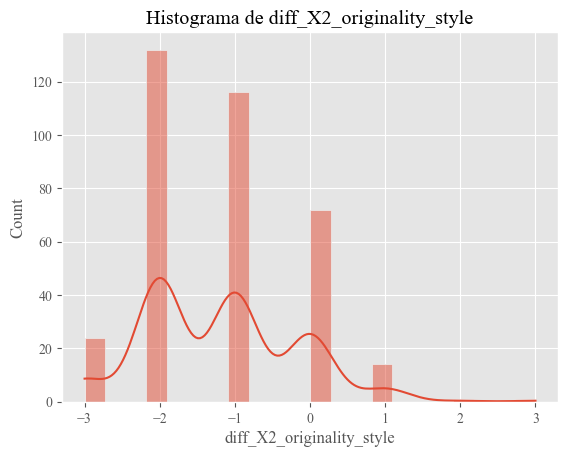

Prueba de Shapiro-Wilk para diff_X2_originality_style: estadístico=0.8969756779549154, p-valor=6.9433582494813575e-15


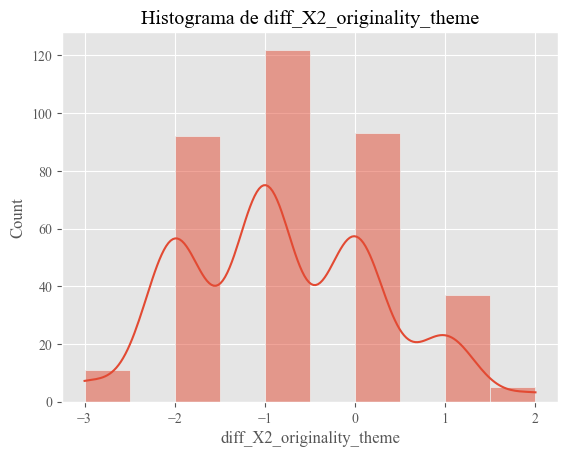

Prueba de Shapiro-Wilk para diff_X2_originality_theme: estadístico=0.9153135085460941, p-valor=2.3571753886150104e-13


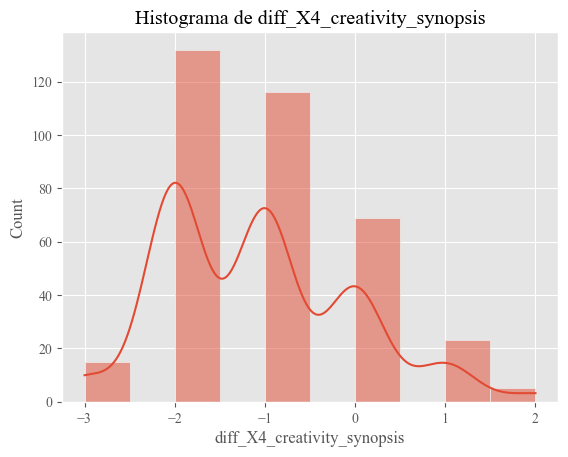

Prueba de Shapiro-Wilk para diff_X4_creativity_synopsis: estadístico=0.8905654019708349, p-valor=2.2469975868310724e-15


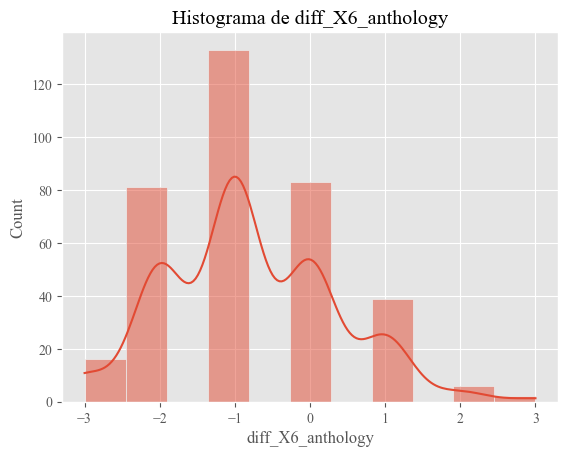

Prueba de Shapiro-Wilk para diff_X6_anthology: estadístico=0.9229074427138875, p-valor=1.1844823071111945e-12


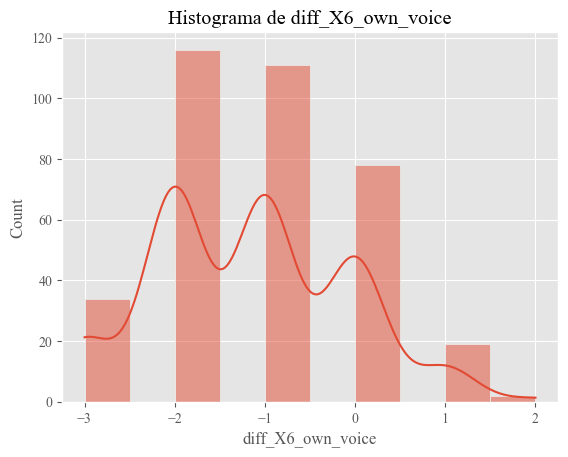

Prueba de Shapiro-Wilk para diff_X6_own_voice: estadístico=0.9144228837920406, p-valor=1.9634040384162851e-13


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Suponiendo que diff_data es tu DataFrame con las differences y la columna 'experiment'

for atributo in attributes:
    diff_col = f'diff_{atributo}'
    if diff_col in differences.columns:
        diff_data = differences[['experiment', diff_col]].dropna()
        if not diff_data.empty:
            # Histograma de las differences
            plt.figure()
            sns.histplot(diff_data[diff_col], kde=True)
            plt.title(f'Histograma de {diff_col}')
            plt.show()
            
            # Prueba de normalidad Shapiro-Wilk
            stat, p_value = stats.shapiro(diff_data[diff_col])
            print(f'Prueba de Shapiro-Wilk para {diff_col}: estadístico={stat}, p-valor={p_value}')
